# import

In [1]:
import os, glob
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import ttest_ind

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

/home/zwkan/miniconda3/envs/EEC289/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ResNet-34 for MNIST

## Model Settings

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:1"
GRAYSCALE = True

## MNIST Dataset

In [3]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [27]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        # probas = F.softmax(logits, dim=1)
        return  logits



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [28]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [30]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        probas = F.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0469 | Cost: 0.0282
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.0294
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.0422
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.0749
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.0292
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.0486
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.0533
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.0511
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.0403
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0526
Epoch: 001/010 | Train: 98.518%
Time elapsed: 0.50 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0028
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0524
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0175
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.1347
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0203
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0701
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0894
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0685
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0204
Epoch: 002/010 | Batch 0450/0469 

## Eval

In [31]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 99.21%


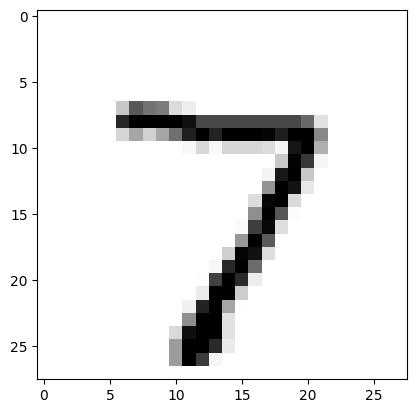

In [32]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [36]:
model.eval()
logits = model(features.to('cuda:1')[0, None])
probas = F.softmax(logits, dim=1)
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


## save resnet

In [37]:
torch.save(model.state_dict(), 'resnet.pth')

# TCAV

## load concept

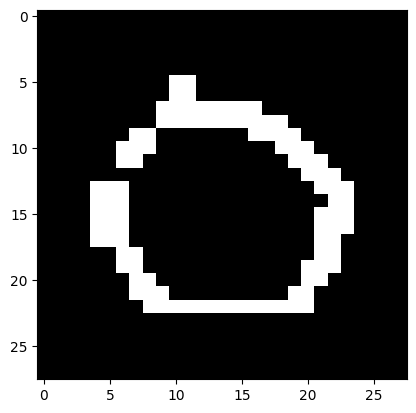

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FILES = ['concept_circle.csv', 'concept_diag_tl_br.csv', 'concept_diag_tr_bl.csv', 'concept_vertical.csv', 'concept_horizontal.csv']
IMAGE_SHAPE = (1,28, 28)

datasets = []
labels = [f.rstrip('.csv').lstrip('concept_') for f in FILES]

for f in FILES:
    df = pd.read_csv(f)
    images = df.to_numpy()
    images = images.reshape(images.shape[0], *IMAGE_SHAPE)
    data_tensor = torch.tensor(images, dtype=torch.float32)
    datasets.append(data_tensor)
    
plt.imshow(datasets[1][0][0], cmap='gray', vmin=0, vmax=255)

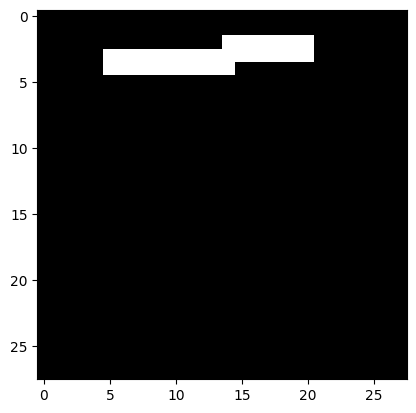

In [214]:
plt.imshow(datasets[4][0][0], cmap='gray', vmin=0, vmax=255)

In [215]:
dataset_dict ={}
names=['concept_circle', 'concept_diaTlBr', 'concept_diagTrBl', 'concept_vertical', 'concept_horizontal']
for i in range(5):
    dataset_dict[names[i]] = datasets[i]

## custom dataset

In [8]:
class ConceptDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        return image

In [9]:
def assemble_concept(name, id, data_tensor):
    concept_dataset = ConceptDataset(data_tensor)
    concept_iter = dataset_to_dataloader(concept_dataset)
    return Concept(id=id, name=name, data_iter=concept_iter)

In [216]:
circle_concept = assemble_concept("concept_circle", 0, data_tensor=datasets[0])
diag_tl_br_concept = assemble_concept("concept_diaTlBr", 1, data_tensor=datasets[1])
diag_tr_bl_concept = assemble_concept("concept_diagTrBl", 2, data_tensor=datasets[2])
vertical_concept = assemble_concept("concept_vertical", 3, data_tensor=datasets[3])
horizontal_concept = assemble_concept("concept_horizontal", 4, data_tensor=datasets[4])

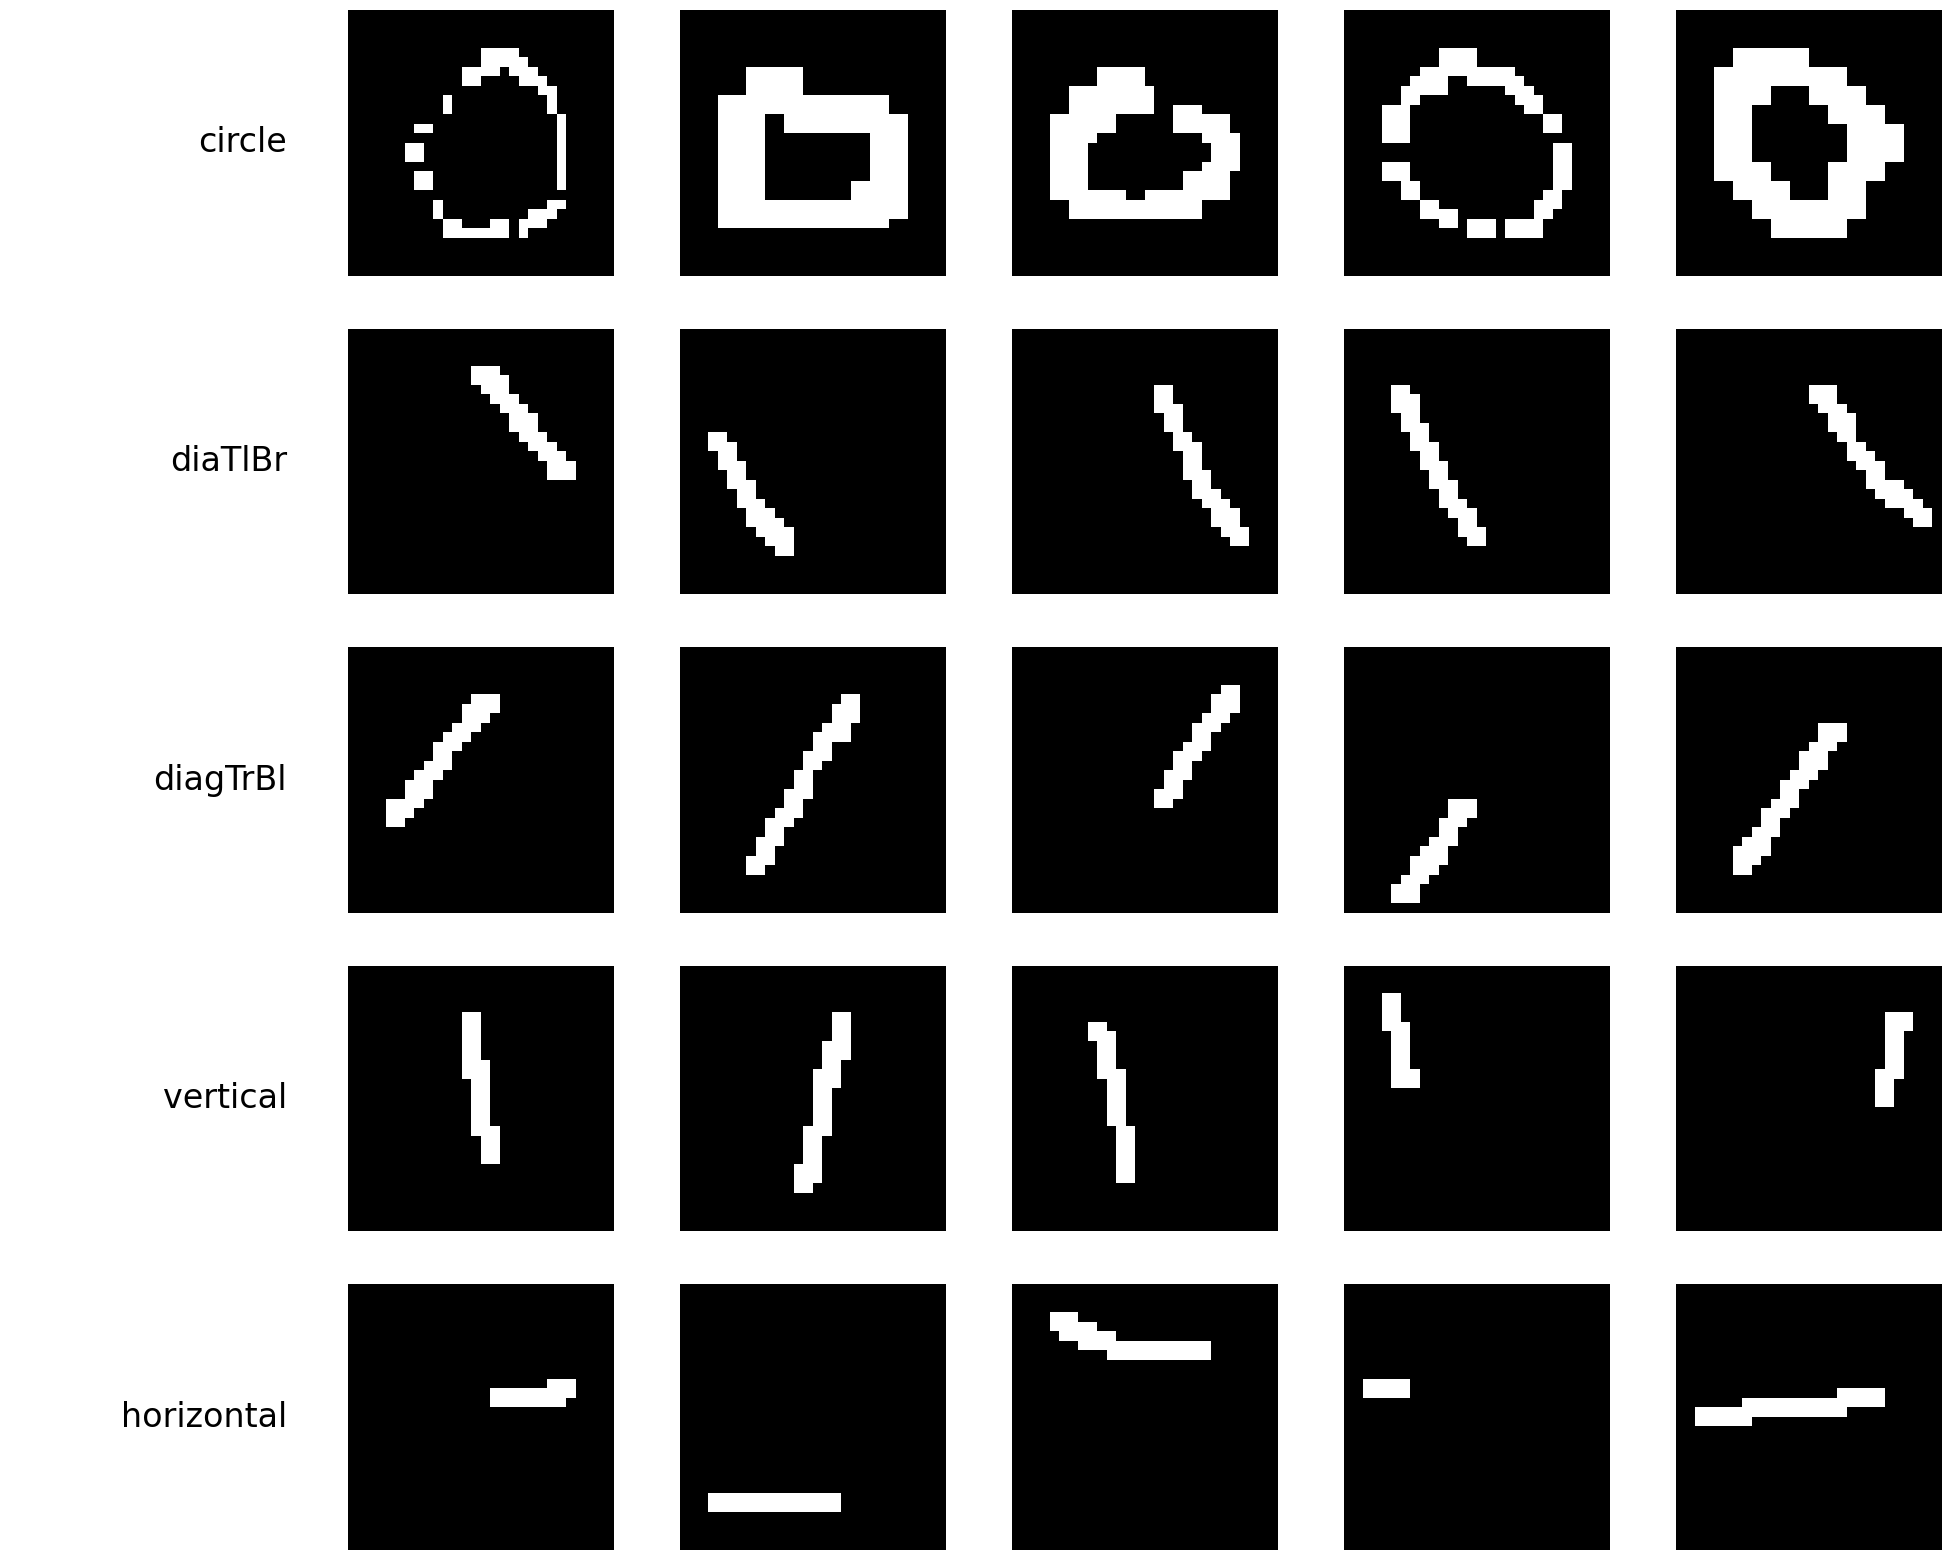

In [217]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

row = 0
for c, concept in dataset_dict.items():
    for i in range(6):
        if i == 0:
            axs[row, i].text(1.0, 0.5, str(c.split('_')[1]), ha='right', va='center', family='sans-serif', size=24)
        else:
            axs[row, i].imshow(concept[i][0], cmap='gray', vmin=0, vmax=255)
        axs[row, i].axis('off')
    row +=1
plt.savefig('concept.png')

In [218]:
model = resnet18(NUM_CLASSES)
model.load_state_dict(torch.load('resnet.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [239]:
results = model(datasets[0])
probas = F.softmax(results,dim=1)
_, predicted_labels = torch.max(probas, 1)
predict_dict_circle = {}

for i in predicted_labels.numpy():
    if i not in predict_dict_circle.keys():
        predict_dict_circle[i] = 1
    else:
        predict_dict_circle[i] += 1

In [241]:
results = model(datasets[1])
probas = F.softmax(results,dim=1)
_, predicted_labels = torch.max(probas, 1)
predict_dict_tlbr = {}

for i in predicted_labels.numpy():
    if i not in predict_dict_tlbr.keys():
        predict_dict_tlbr[i] = 1
    else:
        predict_dict_tlbr[i] += 1

In [247]:
results = model(datasets[2])
probas = F.softmax(results,dim=1)
_, predicted_labels = torch.max(probas, 1)
predict_dict_trbl = {}

for i in predicted_labels.numpy():
    if i not in predict_dict_trbl.keys():
        predict_dict_trbl[i] = 1
    else:
        predict_dict_trbl[i] += 1

In [248]:
results = model(datasets[3])
probas = F.softmax(results,dim=1)
_, predicted_labels = torch.max(probas, 1)
predict_dict_vertical = {}

for i in predicted_labels.numpy():
    if i not in predict_dict_vertical.keys():
        predict_dict_vertical[i] = 1
    else:
        predict_dict_vertical[i] += 1

In [249]:
results = model(datasets[4])
probas = F.softmax(results,dim=1)
_, predicted_labels = torch.max(probas, 1)
predict_dict_horizontal = {}

for i in predicted_labels.numpy():
    if i not in predict_dict_horizontal.keys():
        predict_dict_horizontal[i] = 1
    else:
        predict_dict_horizontal[i] += 1

In [264]:
# Extract keys and values
def visualize_barplot_given_dict(pred_dict,marker):
    for i in range(9):
        if i not in pred_dict.keys():
            pred_dict[i]=0
    keys = list(pred_dict.keys())
    values = list(pred_dict.values())
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='skyblue')
    
    # Add labels and title
    plt.xlabel('Numbers')
    plt.ylabel('Occurrences')
    plt.title(f'Prediction of concept {marker}')
    plt.xticks(keys)
    plt.savefig(f'prediciton_{marker}.png')

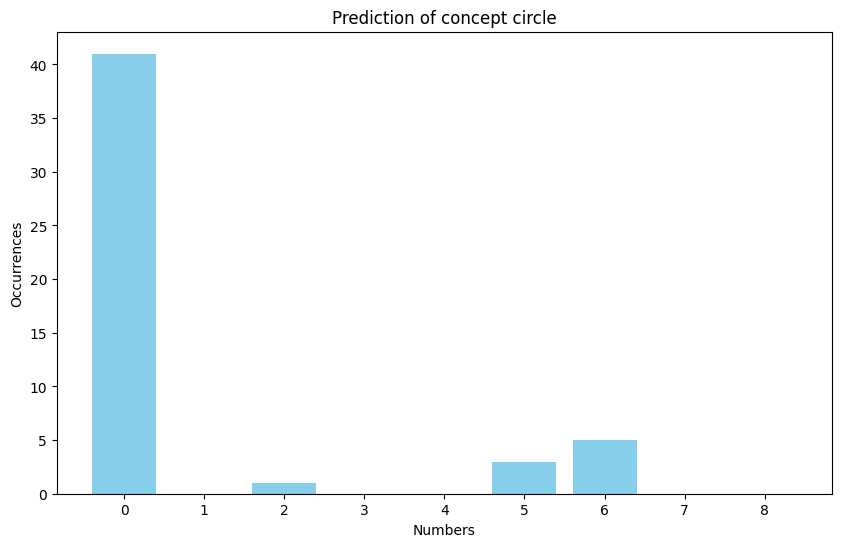

In [265]:
visualize_barplot_given_dict(predict_dict_circle,'circle')

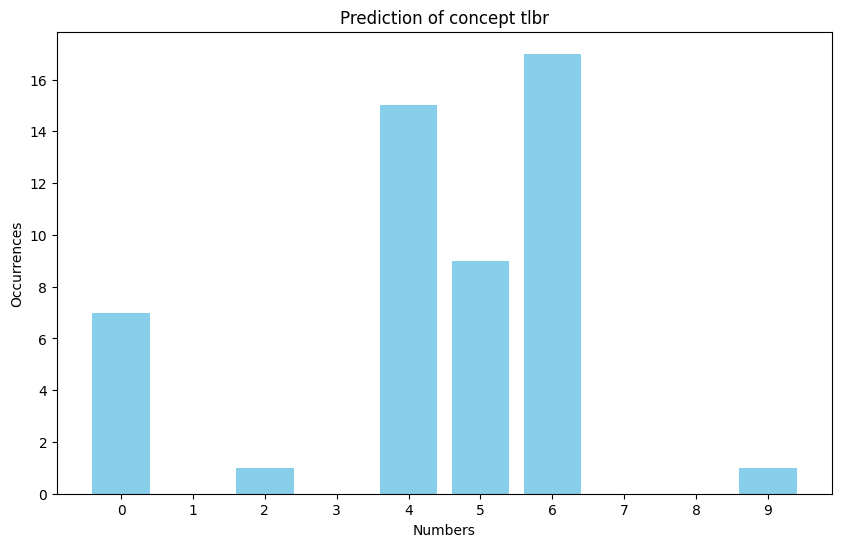

In [266]:
visualize_barplot_given_dict(predict_dict_tlbr,'tlbr')

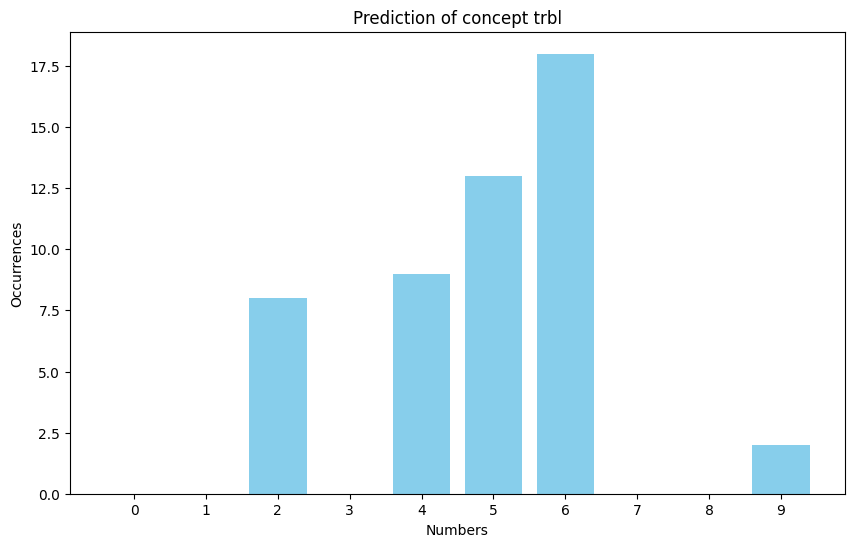

In [267]:
visualize_barplot_given_dict(predict_dict_trbl,'trbl')

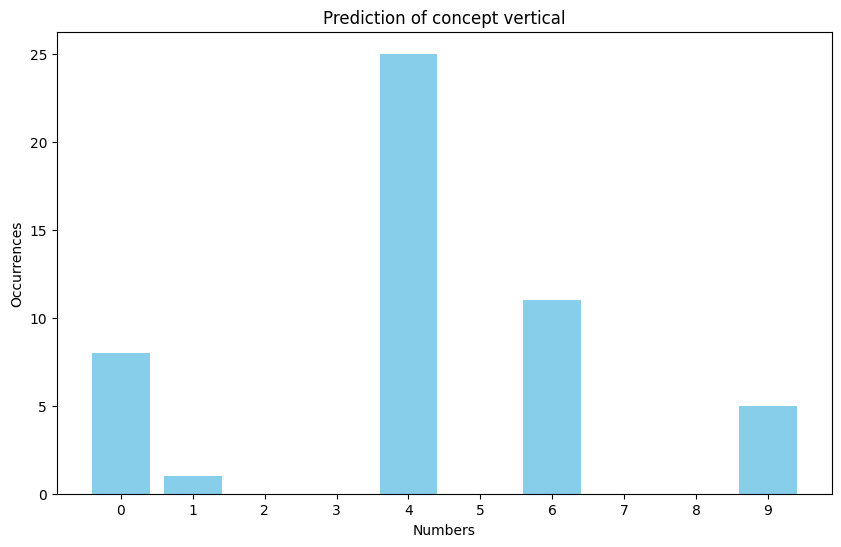

In [268]:
visualize_barplot_given_dict(predict_dict_vertical,'vertical')

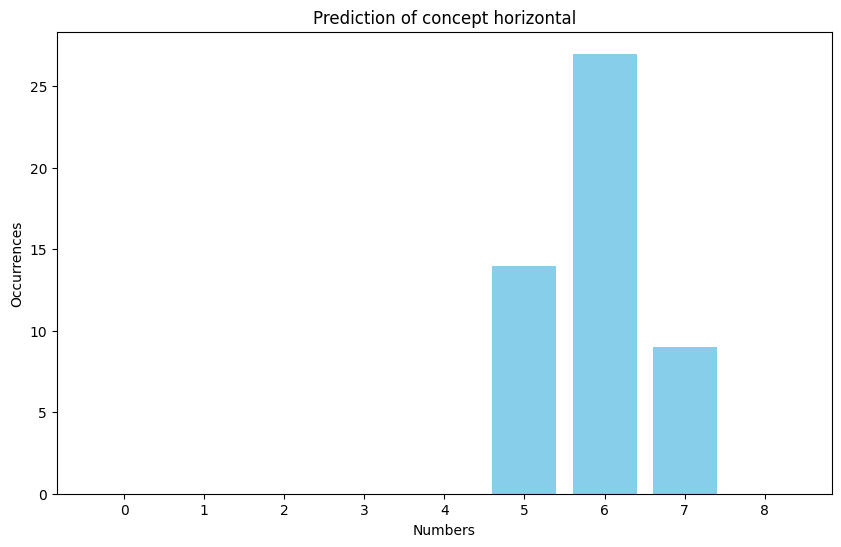

In [269]:
visualize_barplot_given_dict(predict_dict_horizontal,'horizontal')

In [250]:
predict_dict_vertical

{1: 1, 4: 25, 0: 8, 9: 5, 6: 11}

In [251]:
predict_dict_horizontal

{6: 27, 5: 14, 7: 9}

In [219]:
class_images = {i: [] for i in range(10)}
for image, label in test_dataset:
    class_images[label].append(image)

mnist_dict = {i: torch.stack(class_images[i]) for i in range(10)}

for label, image in mnist_dict.items():
    print(f"Label: {label}, Image Tensor Shape: {image.shape}")

Label: 0, Image Tensor Shape: torch.Size([980, 1, 28, 28])
Label: 1, Image Tensor Shape: torch.Size([1135, 1, 28, 28])
Label: 2, Image Tensor Shape: torch.Size([1032, 1, 28, 28])
Label: 3, Image Tensor Shape: torch.Size([1010, 1, 28, 28])
Label: 4, Image Tensor Shape: torch.Size([982, 1, 28, 28])
Label: 5, Image Tensor Shape: torch.Size([892, 1, 28, 28])
Label: 6, Image Tensor Shape: torch.Size([958, 1, 28, 28])
Label: 7, Image Tensor Shape: torch.Size([1028, 1, 28, 28])
Label: 8, Image Tensor Shape: torch.Size([974, 1, 28, 28])
Label: 9, Image Tensor Shape: torch.Size([1009, 1, 28, 28])


In [220]:
zero_tensor = mnist_dict[0][:50]
one_tensor = mnist_dict[1][:50]
two_tensor = mnist_dict[2][:50]
three_tensor = mnist_dict[2][:50]
four_tensor = mnist_dict[4][:50]
five_tensor = mnist_dict[5][:50]
six_tensor = mnist_dict[6][:50]
seven_tensor = mnist_dict[7][:50]
eight_tensor = mnist_dict[8][:50]
nine_tensor = mnist_dict[9][:50]

In [221]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores,marker):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (10, 7))

    barWidth = min(1 / (len(experimental_sets[0]) + 1), 0.2)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        #_ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)
    plt.title(marker)
    plt.savefig(marker+'.png')

## Using layer 4 the last resblock

In [222]:
layers=['layer1','layer2','layer3', 'layer4','fc']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

/home/zwkan/miniconda3/envs/EEC289/lib/python3.12/site-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [199]:
experimental_set = [[circle_concept,vertical_concept,horizontal_concept,diag_tl_br_concept,diag_tr_bl_concept]]

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc1b42840e0>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([1.0000, 0.8800, 0.0000, 0.6000, 0.0000]), 'magnitude': tensor([ 672.8013,   60.6707, -297.4314,    7.5325, -148.1429])}, 'layer2': {'sign_count': tensor([1., 0., 0., 1., 0.]), 'magnitude': tensor([ 293.0712,  -47.0130, -193.8209,   82.6336, -147.2558])}, 'layer3': {'sign_count': tensor([1., 0., 0., 1., 0.]), 'magnitude': tensor([110.6708,  -9.0164, -62.9473,  53.9070, -75.5533])}, 'layer4': {'sign_count': tensor([1., 1., 0., 0., 0.]), 'magnitude': tensor([231.5222,   7.0370, -58.9453, -16.6450, -51.8667])}, 'fc': {'sign_count': tensor([1., 1., 0., 1., 0.]), 'magnitude': tensor([101.8374,  23.9443, -10.0407,  14.7937, -71.3870])}})})


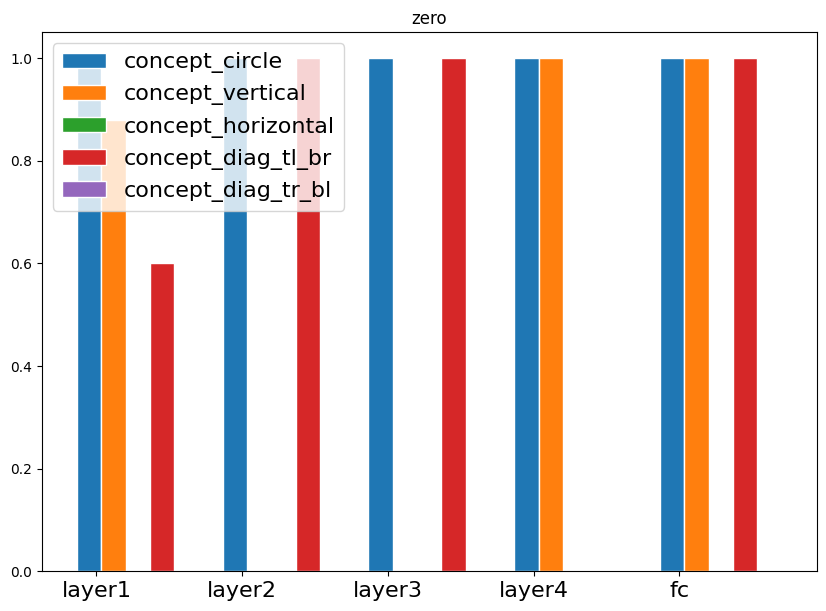

In [200]:
tcav_scores = mytcav.interpret(inputs=zero_tensor,
                                        experimental_sets=experimental_set,
                                        target=0,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='zero') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc25820a2a0>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0., 1., 0., 1., 1.]), 'magnitude': tensor([-163.9284,  383.1031, -161.4588,  109.3219,  196.1953])}, 'layer2': {'sign_count': tensor([0., 1., 0., 1., 1.]), 'magnitude': tensor([-35.6824, 107.1566, -38.1800,  84.7847,  36.6592])}, 'layer3': {'sign_count': tensor([1.0000, 1.0000, 1.0000, 0.1000, 0.0000]), 'magnitude': tensor([ 10.7342,  65.3372,   8.4211,  -2.9545, -15.7714])}, 'layer4': {'sign_count': tensor([0., 1., 1., 1., 0.]), 'magnitude': tensor([-146.0045,  121.2822,  138.7642,    9.5483, -258.8018])}, 'fc': {'sign_count': tensor([0., 1., 1., 1., 0.]), 'magnitude': tensor([-44.5682,  65.9036,  24.3313,  44.2980, -92.3275])}})})


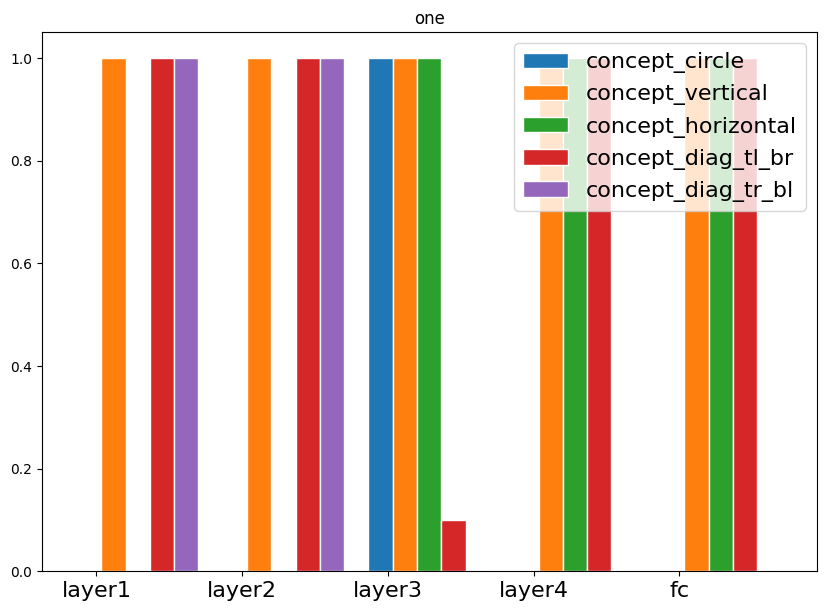

In [274]:
tcav_scores = mytcav.interpret(inputs=one_tensor,
                                        experimental_sets=experimental_set,
                                        target=1,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='one') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc258270cc0>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0.0200, 0.0000, 1.0000, 0.0000, 0.0000]), 'magnitude': tensor([-148.4080, -210.3813,  289.3951, -241.9812, -104.7295])}, 'layer2': {'sign_count': tensor([0.7600, 0.0000, 1.0000, 0.0000, 0.0000]), 'magnitude': tensor([   9.0105,  -74.6970,  124.5609, -167.5141,  -46.3148])}, 'layer3': {'sign_count': tensor([0., 0., 1., 1., 1.]), 'magnitude': tensor([-35.6164, -59.2046,  86.7084,  28.1150,   8.9629])}, 'layer4': {'sign_count': tensor([1., 0., 1., 0., 1.]), 'magnitude': tensor([123.3562, -39.4661,  66.1434, -14.8007,  90.9165])}, 'fc': {'sign_count': tensor([1., 0., 1., 1., 1.]), 'magnitude': tensor([122.2604, -46.1032,  10.4528,  31.3327,  73.4494])}})})


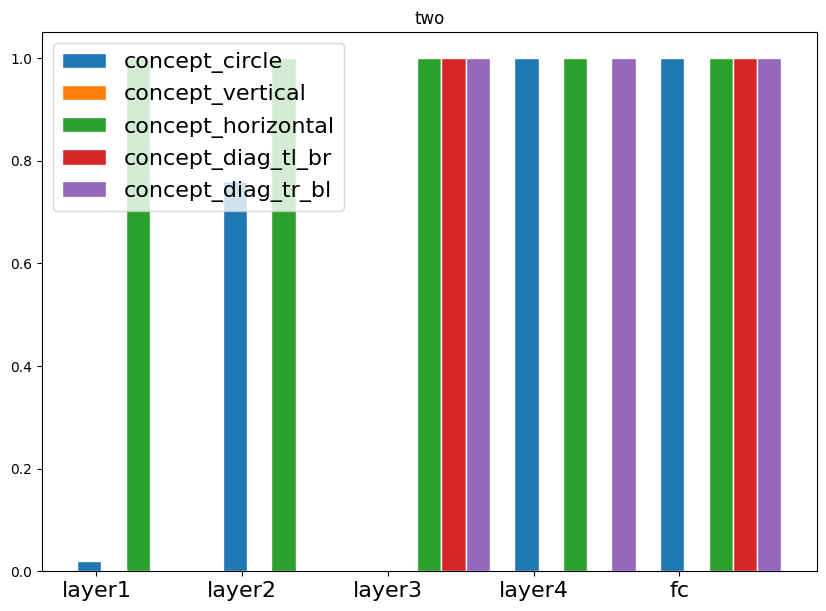

In [275]:
tcav_scores = mytcav.interpret(inputs=two_tensor,
                                        experimental_sets=experimental_set,
                                        target=2,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='two') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc1dc470cc0>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0.8200, 0.0000, 1.0000, 0.6600, 0.0200]), 'magnitude': tensor([  26.5617, -270.0498,  113.8096,   16.1287,  -63.9297])}, 'layer2': {'sign_count': tensor([0.9800, 0.0000, 1.0000, 0.9800, 0.0000]), 'magnitude': tensor([ 17.4797, -83.6200,  71.3526,  32.3947, -22.2138])}, 'layer3': {'sign_count': tensor([0.3600, 0.0000, 1.0000, 1.0000, 1.0000]), 'magnitude': tensor([ -0.2273, -64.2399,  19.3792,  13.2179,  26.9169])}, 'layer4': {'sign_count': tensor([1., 0., 1., 1., 1.]), 'magnitude': tensor([ 128.6488, -123.3089,   61.4358,    4.4079,   38.7578])}, 'fc': {'sign_count': tensor([1., 0., 1., 0., 1.]), 'magnitude': tensor([ 85.7797, -67.2619,  46.4257, -19.4434,  57.5346])}})})


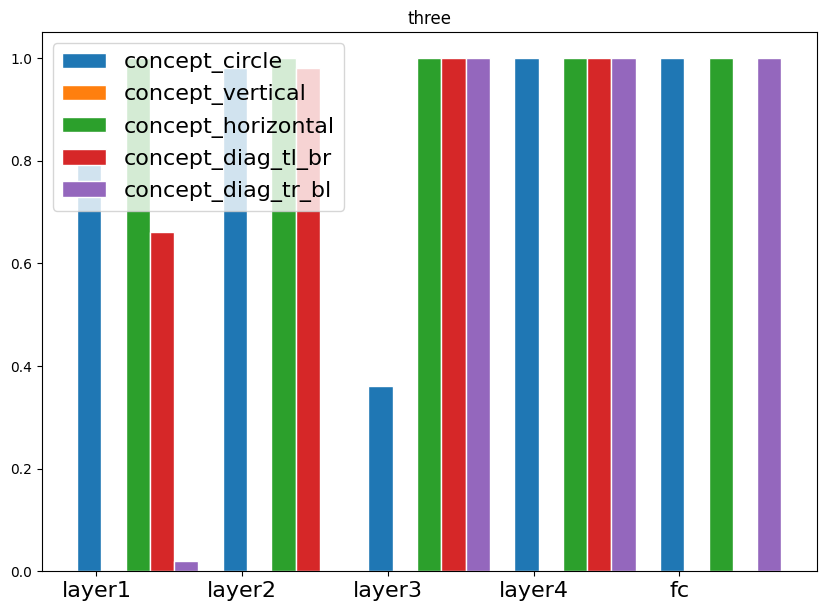

In [276]:
tcav_scores = mytcav.interpret(inputs=three_tensor,
                                        experimental_sets=experimental_set,
                                        target=3,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='three') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc1dc33c360>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0.0400, 1.0000, 0.0000, 1.0000, 0.1400]), 'magnitude': tensor([ -73.8027,  269.2761, -281.1123,  256.4931,  -34.5301])}, 'layer2': {'sign_count': tensor([0.0000, 1.0000, 0.0000, 0.8000, 1.0000]), 'magnitude': tensor([-120.4038,  104.1697,  -69.0642,   14.9158,   89.7117])}, 'layer3': {'sign_count': tensor([0., 1., 0., 1., 1.]), 'magnitude': tensor([ -74.8702,   61.7332, -126.6563,   13.7376,   13.3663])}, 'layer4': {'sign_count': tensor([0., 1., 0., 1., 1.]), 'magnitude': tensor([-245.9531,  159.9760,  -68.7377,    9.0876,   45.6075])}, 'fc': {'sign_count': tensor([0., 1., 0., 1., 1.]), 'magnitude': tensor([-176.4842,   80.4893,  -49.6487,   56.4065,   13.8250])}})})


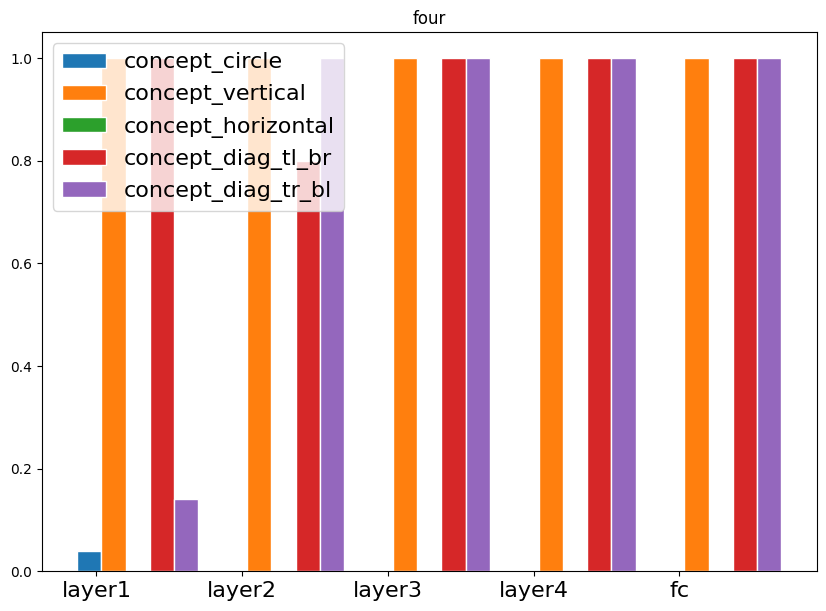

In [277]:
tcav_scores = mytcav.interpret(inputs=four_tensor,
                                        experimental_sets=experimental_set,
                                        target=4,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='four') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc1b441a5c0>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0.8600, 0.0000, 1.0000, 0.9800, 0.0000]), 'magnitude': tensor([  35.5738, -215.7326,  269.2919,   58.0653,  -91.5408])}, 'layer2': {'sign_count': tensor([0.4000, 0.0000, 1.0000, 1.0000, 0.0000]), 'magnitude': tensor([-1.2407e-01, -7.8638e+01,  8.1907e+01,  1.3829e+02, -6.6770e+01])}, 'layer3': {'sign_count': tensor([0., 0., 1., 1., 1.]), 'magnitude': tensor([-15.8937, -40.1460,  14.5474,  39.1609,  10.9214])}, 'layer4': {'sign_count': tensor([1., 0., 1., 1., 0.]), 'magnitude': tensor([ 52.6559, -98.4316, 108.4210,  35.4376, -25.3567])}, 'fc': {'sign_count': tensor([1., 0., 1., 1., 0.]), 'magnitude': tensor([ 16.5567,  -9.9272,  91.1916,  86.4320, -28.9338])}})})


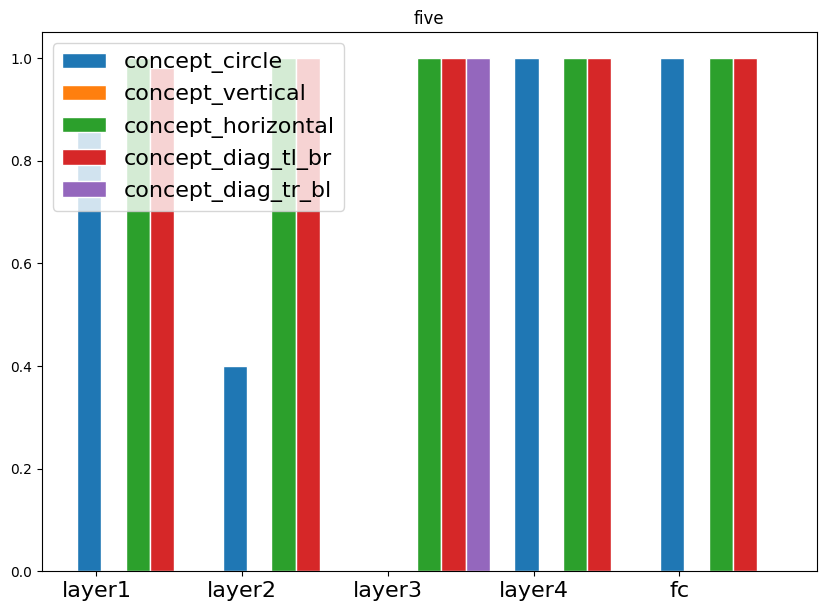

In [278]:
tcav_scores = mytcav.interpret(inputs=five_tensor,
                                        experimental_sets=experimental_set,
                                        target=5,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='five') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc1b40db060>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0.0000, 0.9600, 0.0200, 1.0000, 1.0000]), 'magnitude': tensor([-132.0235,   81.3536, -105.2924,  168.5014,  158.5003])}, 'layer2': {'sign_count': tensor([1.0000, 0.2200, 0.0000, 1.0000, 1.0000]), 'magnitude': tensor([ 51.3308,  -3.8517, -36.4668,  45.7575,  18.4401])}, 'layer3': {'sign_count': tensor([0., 0., 0., 1., 1.]), 'magnitude': tensor([-38.0342, -13.3934, -90.3599,  27.5133,  46.4386])}, 'layer4': {'sign_count': tensor([0., 1., 0., 0., 1.]), 'magnitude': tensor([-10.9294,  30.1216,  -6.8426, -15.2741,  31.6283])}, 'fc': {'sign_count': tensor([1., 0., 1., 0., 1.]), 'magnitude': tensor([ 88.5874, -25.1726,  58.2703,  -3.5446,  90.1393])}})})


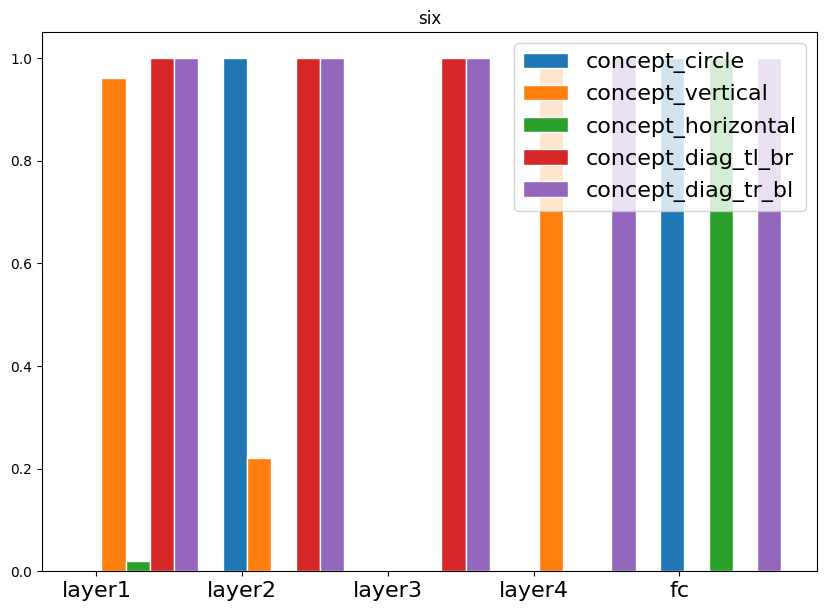

In [279]:
tcav_scores = mytcav.interpret(inputs=six_tensor,
                                        experimental_sets=experimental_set,
                                        target=6,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='six') 

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7fc1ac1b4040>, {'0-3-4-1-2': defaultdict(None, {'layer1': {'sign_count': tensor([0.9600, 0.4000, 1.0000, 0.0000, 1.0000]), 'magnitude': tensor([  67.9578,  -19.1197,  147.5171, -288.6219,  110.6128])}, 'layer2': {'sign_count': tensor([0.0000, 0.2000, 1.0000, 0.0000, 1.0000]), 'magnitude': tensor([ -61.0701,   -3.5932,  155.9273, -135.8923,   26.7506])}, 'layer3': {'sign_count': tensor([0.0000, 0.9800, 1.0000, 0.0000, 0.0000]), 'magnitude': tensor([-13.4005,  10.6395, 142.5665, -61.3335, -24.3458])}, 'layer4': {'sign_count': tensor([0., 0., 1., 0., 1.]), 'magnitude': tensor([-108.8119,  -16.1605,  131.2803, -117.9596,    9.4876])}, 'fc': {'sign_count': tensor([0., 1., 1., 0., 1.]), 'magnitude': tensor([-34.2826,  16.9352, 166.3617, -96.2156,  31.2783])}})})


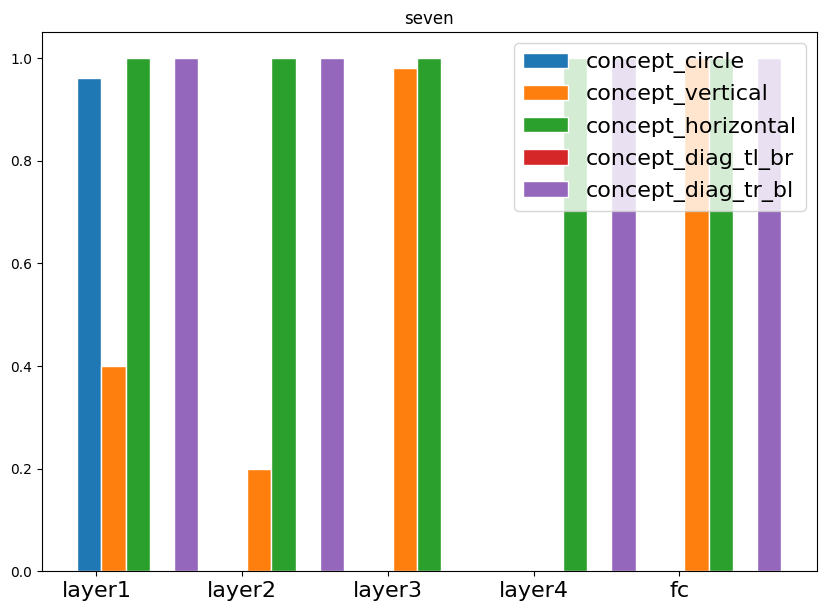

In [280]:
tcav_scores = mytcav.interpret(inputs=seven_tensor,
                                        experimental_sets=experimental_set,
                                        target=7,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='seven') 

In [ ]:
tcav_scores = mytcav.interpret(inputs=eight_tensor,
                                        experimental_sets=experimental_set,
                                        target=8,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='eigtht') 

In [ ]:
tcav_scores = mytcav.interpret(inputs=nine_tensor,
                                        experimental_sets=experimental_set,
                                        target=9,
                                        n_steps=5,
                                       )
print(tcav_scores)
plot_tcav_scores(experimental_set, tcav_scores,marker='nine') 

In [271]:
mnist_dict[0].shape

torch.Size([980, 1, 28, 28])

torch.Size([1, 1, 28, 28])

In [273]:
tcav_scores = mytcav.interpret(inputs=mnist_dict[0][0:1,:,:],
                                        experimental_sets=experimental_set,
                                        target=0,
                                        n_steps=5,
                                       )
print(tcav_scores)

AttributeError: 'int' object has no attribute 'dtype'